# 1. Dependencies

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.Data Preprocessing

In [ ]:
df = pd.read_stata('/content/drive/MyDrive/SNU_Fintech/SNU - 5조/Lending Club/lendingclub.dta')

In [ ]:
df.shape

(1092919, 333)

In [ ]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,...,mths_since_recent_bc4,mths_since_recent_bc5,mths_since_recent_bc6,mths_since_recent_bc7,mths_since_recent_bc8,mths_since_recent_bc9,mths_since_recent_bc10,mths_since_recent_bc11,mths_since_recent_bc_dlq1,mths_since_recent_bc_dlq2,mths_since_recent_bc_dlq3,mths_since_recent_bc_dlq4,mths_since_recent_bc_dlq5,mths_since_recent_bc_dlq6,mths_since_recent_bc_dlq7,mths_since_recent_bc_dlq8,mths_since_recent_bc_dlq9,mths_since_recent_bc_dlq10,mths_since_recent_bc_dlq11,mths_since_recent_inq1,mths_since_recent_inq2,mths_since_recent_inq3,mths_since_recent_inq4,mths_since_recent_inq5,mths_since_recent_inq6,mths_since_recent_inq7,mths_since_recent_inq8,mths_since_recent_inq9,mths_since_recent_inq10,mths_since_recent_revol_delinq1,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
0,19000,19000,19000.0,0.0916,605.62,65000.0,16.36,1,670,674,0,10,0,10644,0.714,27,0.0,0.0,20635.862570,20635.86,19000.00,1635.86,0.0,0.0,0.0,13387.76,734,730,0,0,0,33375,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,10000,10000,10000.0,0.0789,312.86,58000.0,5.03,0,690,694,1,5,0,7940,0.684,6,0.0,0.0,10185.630000,10185.63,10000.00,185.63,0.0,0.0,0.0,9568.68,694,690,0,0,0,151309,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,6000,6000,6000.0,0.1147,197.78,46900.0,24.23,2,665,669,1,9,0,4161,0.257,14,0.0,0.0,7112.021631,7112.02,6000.00,1112.02,0.0,0.0,0.0,197.37,579,575,0,0,0,19337,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,25200,25200,25200.0,0.1199,836.89,76280.0,32.87,0,685,689,0,5,1,7755,0.566,34,0.0,0.0,16704.230000,16704.23,12882.27,3821.96,0.0,0.0,0.0,836.89,564,560,0,0,0,59295,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,8000,8000,8000.0,0.1299,269.52,29000.0,20.28,0,770,774,1,12,0,6324,0.160,15,0.0,0.0,9627.310205,9627.31,8000.00,1627.31,0.0,0.0,0.0,1831.86,684,680,0,0,0,29418,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


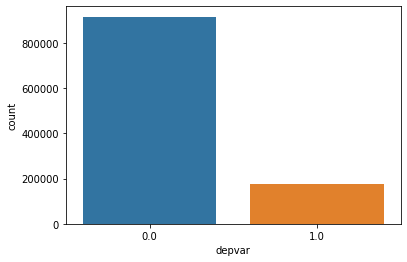

In [ ]:
sns.countplot(x= 'depvar', data = df)

In [ ]:
# 대출 해주는 시점에서 관측 불가능한 변수와 관측 가능한 변수 구분
post_attr = ['out_prncp','out_prncp_inv', 'total_pymnt','total_pymnt_inv', 'total_rec_prncp','total_rec_int',  
'recoveries', 'total_rec_late_fee', 'collection_recovery_fee', 'last_pymnt_amnt', 'debt_settlement_flag1',
'installment','elapsed_t','term1']

for i in range(1,119):
    col = 'issue_d' + str(i)
    post_attr.append(col)

cat_lists = ['mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record',
             'mths_since_rcnt_il','mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_revol_delinq']

for col in cat_lists:
    for i in range(1,12):
        coli = col + str(i)
        post_attr.append(coli)
        
for i in range(1,11):
    col = 'mths_since_recent_inq' + str(i)
    post_attr.append(col)

In [ ]:
pre_attr = list(set(df.columns) - set(post_attr))
pre_attr.sort()

In [ ]:
df = df[pre_attr]
df.shape

(1092919, 114)

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=47)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.25,random_state=73)

### confusion matrix & ploting confusion matirx

In [ ]:
# confusion matrix : fpr, tpr 계산하기
def get_rates(cm):
    
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]
    TN = cm[0,0]

    Recall = TP / (TP + FN) # Sensitivity, hit rate, recall, or true positive rate
    Precision = TP / (TP + FP) # Precision or positive predictive value
    FPR = FP / (FP + TN) # False positive rate or False alarm rate
    # FNR = FN / (FN + TP) # False negative rate or Miss Rate
    Accuracy = (TP+TN) / (FP+FN+TP+TN)

    return Recall, FPR, Precision, Accuracy



# plotting confusion matrix
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    sns.set(rc={'figure.figsize':(10,9)})
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 3. Random Forest Classifier

In [ ]:
# w = {0:1,1:9}
rf_model = RandomForestClassifier(class_weight='balanced',criterion='entropy',max_depth=7,random_state=47)
rf_model.fit(X=X_train, y=y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=47, verbose=0,
                       warm_start=False)

In [ ]:
fi_col2 = []
fi2 = []

for i, column in enumerate(X):
  fi_col2.append(column)
  fi2.append(rf_model.feature_importances_[i])

fi_df2 = zip(fi_col2, fi2)
fi_df2 = pd.DataFrame(fi_df2, columns=['features', 'feature importance'])
fi_df2 = fi_df2.sort_values('feature importance', ascending=False).reset_index()

idx_to_drop2 = fi_df2.index[fi_df2['feature importance'] == 0].tolist()
fi_df2.drop(index = idx_to_drop2,inplace=True) # feature importance 가 0인 변수들 제거
print(fi_df2.shape) # 113개 중에 111개 생존
fi_df2.head()

(111, 3)


,index,features,feature importance
0,84,last_fico_range_high,0.446779
1,85,last_fico_range_low,0.438049
2,83,int_rate,0.046423
3,70,fico_range_high,0.011368
4,71,fico_range_low,0.010357


feature importance 반영하여 돌린 결과

In [ ]:
featlist = list(fi_df2["features"])
X = df[featlist]
y = df['depvar']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=47)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.25,random_state=73)

# w = {0:1,1:9}
rf_model = RandomForestClassifier(class_weight='balanced',criterion='entropy',max_depth=7,random_state=47)
rf_model.fit(X=X_train, y=y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=47, verbose=0,
                       warm_start=False)

In [ ]:
valid_pred2 = rf_model.predict(X_valid)
valid_pred_prob2 = rf_model.predict_proba(X_valid) # 각 column : 0(살아날)일 확률 & 1(부도할) 확률

In [ ]:
# roc_curve & auc
fpr, tpr, threshold = roc_curve(y_valid,valid_pred_prob2[:,1])
roc_auc = auc(fpr,tpr)
roc_auc

0.9183001398240356

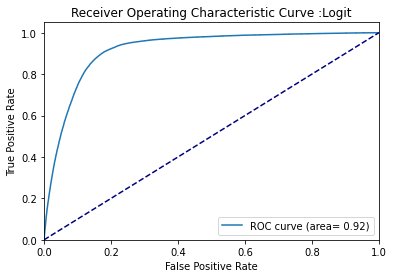

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc)
ㅁ
##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [ ]:
threshold_interval = np.linspace(0,1,101)

for i in threshold_interval:
    test_result_temp0 = pd.DataFrame(rf_model.predict_proba(X_test)[:,1],columns=['pred_prob'])
    test_result_temp0['binary'] = np.where(test_result_temp0['pred_prob']>=(i-0.01),1,0)

    test_result_temp1 = pd.DataFrame(rf_model.predict_proba(X_test)[:,1],columns=['pred_prob'])
    test_result_temp1['binary'] = np.where(test_result_temp1['pred_prob']>=i,1,0)
    
    cm_temp0 = confusion_matrix(y_test,test_result_temp0['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    cm_temp1 = confusion_matrix(y_test,test_result_temp1['binary'])
    cm_norm_temp1 = cm_temp1 / cm_temp1.sum(axis=1).reshape(-1,1)

    print(i)
    print(-4.5*12*(cm_norm_temp1[0,1]-cm_norm_temp0[0,1])>33*(cm_norm_temp1[1,0]-cm_norm_temp0[1,0]))
    print("accuracy is :", (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1]))
    print('')

0.0
False
accuracy is : 0.1615488782344545

0.01
False
accuracy is : 0.1615488782344545

0.02
False
accuracy is : 0.1615488782344545

0.03
False
accuracy is : 0.1615488782344545

0.04
False
accuracy is : 0.1615488782344545

0.05
False
accuracy is : 0.1615488782344545

0.06
True
accuracy is : 0.16157175273579036

0.07
True
accuracy is : 0.16297624711781283

0.08
True
accuracy is : 0.1695869780038795

0.09
True
accuracy is : 0.18139937049372323

0.1
True
accuracy is : 0.19750301943417634

0.11
True
accuracy is : 0.21754108260439922

0.12
True
accuracy is : 0.24100574607473557

0.13
True
accuracy is : 0.27004263807049006

0.14
True
accuracy is : 0.3037550781392966

0.15
True
accuracy is : 0.3419966694726055

0.16
True
accuracy is : 0.3836968854078981

0.17
True
accuracy is : 0.4285400578267394

0.18
True
accuracy is : 0.47389561907550415

0.19
True
accuracy is : 0.5187342165940783

0.2
True
accuracy is : 0.5600318413058595

0.21
True
accuracy is : 0.5984610035501227

0.22
True
accuracy is

* optimal_threshold_rf = 0.65
* accuracy : 0.8581735168173333

In [ ]:
optimal_threshold_rf = 0.65

# test set 검증
test_result2 = pd.DataFrame(rf_model.predict_proba(X_test)[:,1],columns=['pred_prob'])
test_result2['rf_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_rf,1,0)

In [ ]:
test_result2

,pred_prob,rf_binary
0,0.183090,0
1,0.191853,0
2,0.199716,0
3,0.202154,0
4,0.823006,1
...,...,...
218579,0.588713,0
218580,0.154994,0
218581,0.747689,1
218582,0.211239,0


In [ ]:
cm2 = confusion_matrix(y_test,test_result2['rf_binary'])
cm2

array([[157390,  25882],
       [  5119,  30193]])

In [ ]:
print(classification_report(y_test, test_result2['rf_binary']))

              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91    183272
         1.0       0.54      0.86      0.66     35312

    accuracy                           0.86    218584
   macro avg       0.75      0.86      0.79    218584
weighted avg       0.90      0.86      0.87    218584



In [ ]:
tpr, fpr, prc, acc =  get_rates(cm2)
print("TPR : {:.2f}%".format(tpr*100))
print("FPR : {:.2f}%".format(fpr*100))
print("Precision : {:.2f}%".format(prc*100))
print("Accuracy : {:.2f}%".format(acc*100))

TPR : 85.50%
FPR : 14.12%
Precision : 53.84%
Accuracy : 85.82%


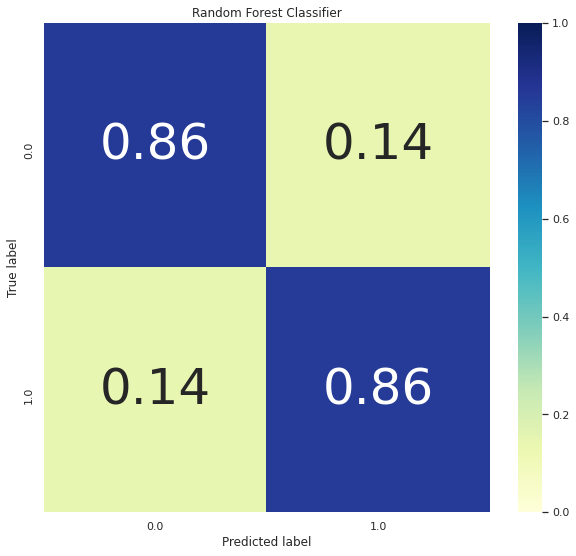

In [ ]:
cm2_norm = cm2 / cm2.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm2_norm, classes = rf_model.classes_, title='Random Forest Classifier')

# 4. Logistic Regression

* Feature Selectoin : DecisionTree / Lasso 

## I) Feature Selection : Decision Tree

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=47)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.25,random_state=73)

In [ ]:
dt_model = DecisionTreeClassifier(random_state=43, criterion='entropy',max_depth=10,class_weight='balanced')
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=43, splitter='best')

In [ ]:
fi_col1 = []
fi1 = []

for i, column in enumerate(X):
  fi_col1.append(column)
  fi1.append(dt_model.feature_importances_[i])

fi_df1 = pd.DataFrame(zip(fi_col1, fi1), columns=['features', 'feature importance'])
fi_df1 = fi_df1.sort_values('feature importance', ascending=False).reset_index()
idx_to_drop = fi_df1.index[fi_df1['feature importance'] == 0].tolist()
fi_df1.drop(index = idx_to_drop,inplace=True) # feature importance 가 0인 변수들 제거
print(fi_df1.shape) # 113개중에 75개 살아남음
fi_df1.head()

(75, 3)


,index,features,feature importance
0,85,last_fico_range_low,0.906617
1,84,last_fico_range_high,0.021945
2,72,funded_amnt,0.010985
3,83,int_rate,0.009709
4,61,emp_length12,0.007586


In [ ]:
X_train_dt = X_train[fi_df1.features]
X_valid_dt = X_valid[fi_df1.features]
X_test_dt = X_test[fi_df1.features]

print(X_train_dt.shape)
print(X_valid_dt.shape)
print(X_test_dt.shape)

(655751, 75)
(218584, 75)
(218584, 75)


In [ ]:
w = {0:1, 1:4.5}
log_reg_dt = LogisticRegression(penalty="none", random_state=37, solver='saga', class_weight='balanced')
log_reg_dt.fit(X_train_dt, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=37, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:
y_pred_dt = log_reg_dt.predict(X_train_dt)
pred_prob_dt = log_reg_dt.predict_proba(X_train_dt)
log_reg_dt.coef_
print("Predicted classes for train set are:{}".format(y_pred_dt) , "The coefficients are : {}".format(log_reg_dt.coef_), "Odds are:{}".format(np.exp(log_reg_dt.coef_)), sep='\n')

Predicted classes for train set are:[1. 1. 0. ... 1. 1. 0.]
The coefficients are : [[-1.36660043e-06 -8.91712825e-07  7.11356349e-06  2.70175087e-10
   2.41772428e-10  7.11050547e-06  1.13824826e-08  2.30973229e-08
  -2.23276772e-06  4.68650406e-10 -1.23339842e-06 -3.67024505e-07
   1.70991518e-07  7.11342348e-06  1.72462103e-07  8.27957055e-09
   2.19884181e-07  4.29562892e-10  5.34731251e-10  1.97093397e-09
   3.13261128e-10  6.78820645e-10 -1.54868454e-10  5.22730862e-10
   2.72314198e-10 -4.03725697e-11  9.76525908e-11 -6.24219364e-10
  -1.17854108e-10 -2.47397046e-10 -1.60390730e-11 -8.11497166e-12
   2.19049700e-11  1.17970904e-11 -3.15096995e-10  9.94445664e-08
  -2.97479502e-11  2.65858669e-11 -7.65924151e-12  4.94603337e-11
   5.20675174e-10  9.28945669e-11  4.38173545e-11 -1.91616350e-11
   1.82520514e-11  2.69993433e-11  1.80181921e-12  3.29776895e-12
   2.16702800e-11 -1.62994374e-11  2.31312516e-11 -7.77275666e-12
   1.92310922e-11  1.10886400e-12  1.95471344e-11  2.308074

In [ ]:
pred_prob_dt

array([[0.47303591, 0.52696409],
       [0.49847566, 0.50152434],
       [0.56623378, 0.43376622],
       ...,
       [0.43744666, 0.56255334],
       [0.42182371, 0.57817629],
       [0.50362687, 0.49637313]])

In [ ]:
print("Train accuracy is: ", log_reg_dt.score(X_train_dt, y_train))
print("Test accuracy is: ", log_reg_dt.score(X_test_dt, y_test))
print(classification_report(y_train, y_pred_dt))

Train accuracy is:  0.5488394222807133
Test accuracy is:  0.5501317571276946
              precision    recall  f1-score   support

         0.0       0.87      0.54      0.67    549698
         1.0       0.20      0.58      0.29    106053

    accuracy                           0.55    655751
   macro avg       0.53      0.56      0.48    655751
weighted avg       0.76      0.55      0.61    655751



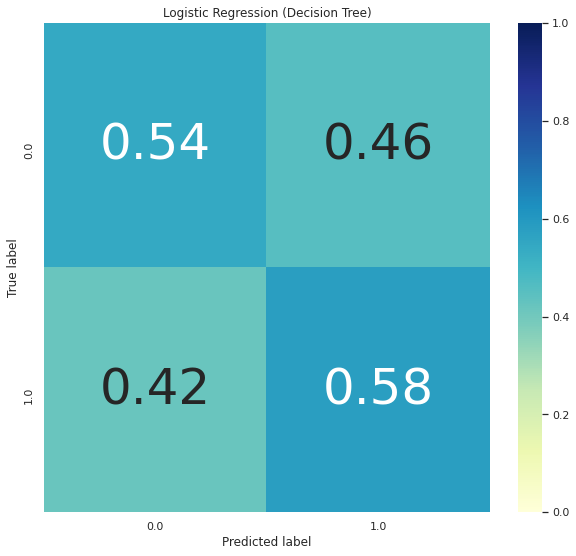

In [ ]:
cm = confusion_matrix(y_train, y_pred_dt)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg_dt.classes_, title='Logistic Regression (Decision Tree)')

In [ ]:
print(cm, cm_norm, sep='\n\n\n')

[[405403 144295]
 [ 65988  40065]]


[[0.73750132 0.26249868]
 [0.62221719 0.37778281]]


In [ ]:
pred_proba_valid = log_reg_dt.predict_proba(X_valid_dt)
fpr, tpr, thresholds = roc_curve(y_valid,pred_proba_valid[:,1])
roc_auc_logit = auc(fpr, tpr)
roc_auc_logit

0.5878683787178327

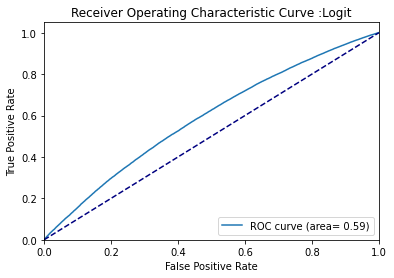

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc_logit)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# finding optimal threshold
for i in threshold_interval:
    valid_result_temp0 = pd.DataFrame(log_reg_dt.predict_proba(X_valid_dt)[:,1],columns=['pred_prob'])
    valid_result_temp0['binary'] = np.where(valid_result_temp0['pred_prob']>=(i-0.01),1,0)

    valid_result_temp1 = pd.DataFrame(log_reg_dt.predict_proba(X_valid_dt)[:,1],columns=['pred_prob'])
    valid_result_temp1['binary'] = np.where(valid_result_temp1['pred_prob']>=i,1,0)
    
    cm_temp0 = confusion_matrix(y_test,valid_result_temp0['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    cm_temp1 = confusion_matrix(y_test,valid_result_temp1['binary'])
    cm_norm_temp1 = cm_temp1 / cm_temp1.sum(axis=1).reshape(-1,1)
    # print("1-fpr : tpr = {} : {}".format(a*5/100,1-(a*5/100)))
    # print("optimal threshold : {}".format(np.ceil(optimal_threshold_logit_temp*1000)/1000))
    print(i)
    print(-4.5*12*(cm_norm_temp1[0,1]-cm_norm_temp0[0,1])>33*(cm_norm_temp1[1,0]-cm_norm_temp0[1,0]))
    print("accuracy is :", (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1]))
    print('')

0.0
False
accuracy is : 0.1615488782344545

0.01
True
accuracy is : 0.1617410240456758

0.02
True
accuracy is : 0.16182337225048493

0.03
True
accuracy is : 0.16190572045529408

0.04
False
accuracy is : 0.16198349375983603

0.05
True
accuracy is : 0.16208414156571388

0.06
True
accuracy is : 0.16220766387292757

0.07
False
accuracy is : 0.1622945869780039

0.08
True
accuracy is : 0.1624318339860191

0.09
True
accuracy is : 0.16264685429857628

0.1
True
accuracy is : 0.16280697580792738

0.11
True
accuracy is : 0.1629670973172785

0.12
True
accuracy is : 0.16315466822823263

0.13
True
accuracy is : 0.16336968854078981

0.14
True
accuracy is : 0.16360758335468287

0.15
True
accuracy is : 0.16394612597445377

0.16
True
accuracy is : 0.1643487171979651

0.17
True
accuracy is : 0.16472843392014055

0.18
True
accuracy is : 0.16513560004391906

0.19
True
accuracy is : 0.16555649086849908

0.2
True
accuracy is : 0.1662061267064378

0.21
True
accuracy is : 0.16680086374117045

0.22
True
accurac

* optimal_threshold_df_lg = 0.62
* accuracy : 0.8384465468652783

In [ ]:
optimal_threshold_df_lg = 0.62

# test set 검증
test_result_lg1 = pd.DataFrame(log_reg_dt.predict_proba(X_test_dt)[:,1],columns=['pred_prob'])
test_result_lg1['rf_binary'] = np.where(test_result_lg1['pred_prob']>=optimal_threshold_df_lg,1,0)

In [ ]:
test_result_lg1

,pred_prob,rf_binary
0,0.529090,0
1,0.499169,0
2,0.495492,0
3,0.568262,0
4,0.521806,0
...,...,...
218579,0.434723,0
218580,0.471269,0
218581,0.450444,0
218582,0.411573,0


In [ ]:
cm2 = confusion_matrix(y_test,test_result_lg1['rf_binary'])
cm2

array([[183271,      1],
       [ 35312,      0]])

In [ ]:
print(classification_report(y_test, test_result_lg1['rf_binary']))

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183272
         1.0       0.00      0.00      0.00     35312

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
tpr, fpr, prc, acc =  get_rates(cm2)
print("TPR : {:.2f}%".format(tpr*100))
print("FPR : {:.2f}%".format(fpr*100))
print("Precision : {:.2f}%".format(prc*100))
print("Accuracy : {:.2f}%".format(acc*100))

TPR : 0.00%
FPR : 0.00%
Precision : 0.00%
Accuracy : 83.84%


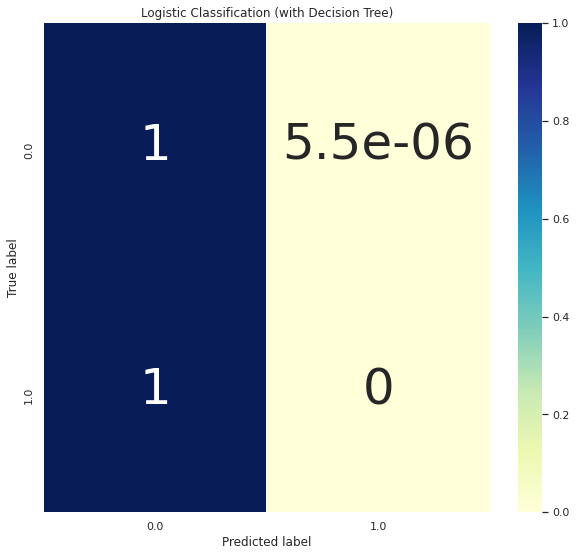

In [ ]:
cm2_norm = cm2 / cm2.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm2_norm, classes = rf_model.classes_, title='Logistic Classification (with Decision Tree)')

## II) Featuer Selection : Lasso

In [ ]:
w = {0:1, 1:4.5}
log_reg_ls = LogisticRegression(penalty = 'elasticnet',random_state=37, solver='saga', class_weight=w, l1_ratio=1e-3)
log_reg_ls.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight={0: 1, 1: 4.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.1,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=37, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [ ]:
fi_col4 = []
fi4 = []

for i, column in enumerate(X):
  fi_col4.append(column)
  fi4.append(log_reg_ls.coef_[0][i])

fi_df4 = zip(fi_col4, fi4)
fi_df4 = pd.DataFrame(fi_df4, columns=['features', 'feature importance'])
fi_df4 = fi_df4.sort_values('feature importance', ascending=False).reset_index()

idx_to_drop3 = fi_df4.index[fi_df4['feature importance'] == 0].tolist()
fi_df4.drop(index = idx_to_drop3,inplace=True) # feature importance 가 0인 변수들 제거
print(fi_df4.shape) # 114개중에 113개 살아남음 
fi_df4

(113, 3)


,index,features,feature importance
0,72,funded_amnt,6.849531e-06
1,86,loan_amnt,6.849305e-06
2,73,funded_amnt_inv,6.847048e-06
3,107,tot_coll_amt,2.082114e-07
4,56,delinq_amnt,1.526020e-07
...,...,...,...
108,104,revol_bal,-9.876549e-07
109,108,tot_cur_bal,-1.220849e-06
110,84,last_fico_range_high,-1.732486e-06
111,85,last_fico_range_low,-2.447301e-06


In [ ]:
X_train_ls = X_train[fi_df4.features]
X_valid_ls = X_valid[fi_df4.features]
X_test_ls = X_test[fi_df4.features]

In [ ]:
y_pred_ls = log_reg_ls.predict(X_train_ls)
pred_prob_ls = log_reg_ls.predict_proba(X_train_ls)
log_reg_dt.coef_
print("Predicted classes for train set are:{}".format(y_pred_dt) , "The coefficients are : {}".format(log_reg_dt.coef_), "Odds are:{}".format(np.exp(log_reg_dt.coef_)), sep='\n')

Predicted classes for train set are:[1. 0. 0. ... 1. 1. 0.]
The coefficients are : [[-2.44730077e-06 -1.73248571e-06  6.84953086e-06  3.40318346e-10
   3.06152535e-10  6.84704819e-06  6.89016290e-09  2.41630956e-08
  -3.44864293e-06  4.48148568e-10 -1.22084942e-06 -9.87654904e-07
  -1.13888796e-07  6.84930541e-06 -1.13816410e-07  7.46618838e-09
   2.08211372e-07  5.24864760e-10  6.85065192e-10  2.71921385e-09
   2.90217266e-10  8.88722885e-10 -5.32209537e-10  5.50646884e-10
   3.17036775e-10 -8.27527027e-11  1.06448260e-10 -1.16050280e-09
  -3.11001363e-10 -5.29828123e-10 -3.09724333e-11 -3.13486487e-11
   2.30594606e-11 -1.90949850e-11 -6.07657706e-10  1.52601976e-07
  -5.73015471e-11  1.70933373e-11 -2.25217368e-11  6.50682310e-11
   4.71864514e-10  1.29800809e-10 -5.40929642e-12 -3.68125870e-11
   2.26475501e-11  2.14935186e-11  1.17312406e-12  3.57614747e-12
   1.02530365e-11 -3.05993992e-11  2.37821420e-11 -1.33536003e-11
   2.44941563e-11  6.11112165e-13  1.33173346e-11  1.129872

In [ ]:
pred_prob_ls

array([[0.50422335, 0.49577665],
       [0.50638757, 0.49361243],
       [0.50199767, 0.49800233],
       ...,
       [0.50872874, 0.49127126],
       [0.50080597, 0.49919403],
       [0.50284557, 0.49715443]])

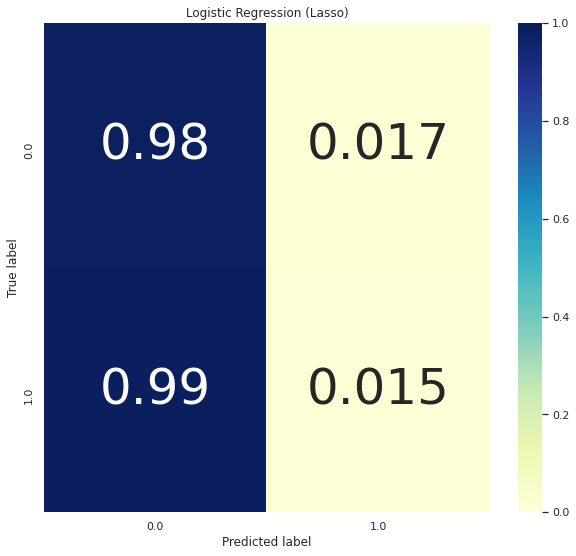

In [ ]:
cm = confusion_matrix(y_train, y_pred_ls)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg_ls.classes_, title='Logistic Regression (Lasso)')

In [ ]:
print(cm, cm_norm, sep='\n\n\n')

[[540253   9445]
 [104471   1582]]


[[0.98281784 0.01718216]
 [0.98508293 0.01491707]]


In [ ]:
pred_proba_valid = log_reg_ls.predict_proba(X_valid_ls)
fpr, tpr, thresholds = roc_curve(y_valid,pred_proba_valid[:,1])
roc_auc_logit = auc(fpr, tpr)
roc_auc_logit

0.5161225368682785

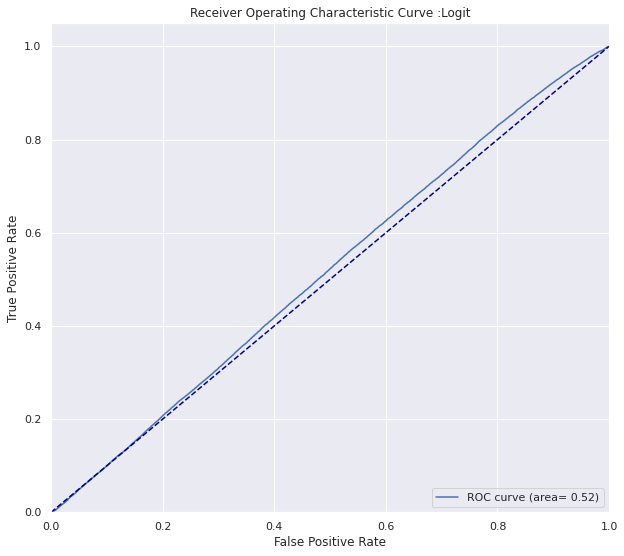

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)' % roc_auc_logit)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# finding optimal threshold
for i in threshold_interval:
    valid_result_temp0 = pd.DataFrame(log_reg_ls.predict_proba(X_valid_ls)[:,1],columns=['pred_prob'])
    valid_result_temp0['binary'] = np.where(valid_result_temp0['pred_prob']>=(i-0.01),1,0)

    valid_result_temp1 = pd.DataFrame(log_reg_ls.predict_proba(X_valid_ls)[:,1],columns=['pred_prob'])
    valid_result_temp1['binary'] = np.where(valid_result_temp1['pred_prob']>=i,1,0)
    
    cm_temp0 = confusion_matrix(y_test,valid_result_temp0['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    cm_temp1 = confusion_matrix(y_test,valid_result_temp1['binary'])
    cm_norm_temp1 = cm_temp1 / cm_temp1.sum(axis=1).reshape(-1,1)
    
    # print("1-fpr : tpr = {} : {}".format(a*5/100,1-(a*5/100)))
    # print("optimal threshold : {}".format(np.ceil(optimal_threshold_logit_temp*1000)/1000))
    print(i)
    print(-4.5*12*(cm_norm_temp1[0,1]-cm_norm_temp0[0,1])>33*(cm_norm_temp1[1,0]-cm_norm_temp0[1,0]))
    print("accuracy is :", (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1]))
    print('')

0.0
False
accuracy is : 0.1615488782344545

0.01
False
accuracy is : 0.1615488782344545

0.02
False
accuracy is : 0.1615488782344545

0.03
False
accuracy is : 0.1615488782344545

0.04
False
accuracy is : 0.1615488782344545

0.05
True
accuracy is : 0.16155345313472166

0.06
False
accuracy is : 0.16155345313472166

0.07
False
accuracy is : 0.16155345313472166

0.08
False
accuracy is : 0.16155345313472166

0.09
False
accuracy is : 0.16155345313472166

0.1
False
accuracy is : 0.16155345313472166

0.11
False
accuracy is : 0.16155345313472166

0.12
False
accuracy is : 0.16155345313472166

0.13
False
accuracy is : 0.16155345313472166

0.14
False
accuracy is : 0.16155345313472166

0.15
False
accuracy is : 0.16155345313472166

0.16
False
accuracy is : 0.16155345313472166

0.17
False
accuracy is : 0.16155345313472166

0.18
False
accuracy is : 0.16155345313472166

0.19
False
accuracy is : 0.16155345313472166

0.2
True
accuracy is : 0.16155802803498884

0.21
False
accuracy is : 0.16155802803498884

* optimal_threshold_ls_lg = 0.51
* accuracy : 0.8384511217655455

In [ ]:
optimal_threshold_ls_lg = 0.51

# test set 검증
test_result_lg2 = pd.DataFrame(log_reg_ls.predict_proba(X_test_ls)[:,1],columns=['pred_prob'])
test_result_lg2['rf_binary'] = np.where(test_result_lg2['pred_prob']>=optimal_threshold_ls_lg,1,0)

In [ ]:
test_result_lg2

,pred_prob,rf_binary
0,0.485737,0
1,0.497067,0
2,0.497676,0
3,0.487843,0
4,0.498908,0
...,...,...
218579,0.498401,0
218580,0.491635,0
218581,0.486159,0
218582,0.499007,0


In [ ]:
cm2 = confusion_matrix(y_test,test_result_lg2['rf_binary'])
cm2

array([[183272,      0],
       [ 35312,      0]])

In [ ]:
print(classification_report(y_test, test_result_lg2['rf_binary']))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183272
         1.0       0.00      0.00      0.00     35312

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
tpr, fpr, prc, acc =  get_rates(cm2)
print("TPR : {:.2f}%".format(tpr*100))
print("FPR : {:.2f}%".format(fpr*100))
print("Precision : {:.2f}%".format(prc*100))
print("Accuracy : {:.2f}%".format(acc*100))

TPR : 0.00%
FPR : 0.00%
Precision : nan%
Accuracy : 83.85%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


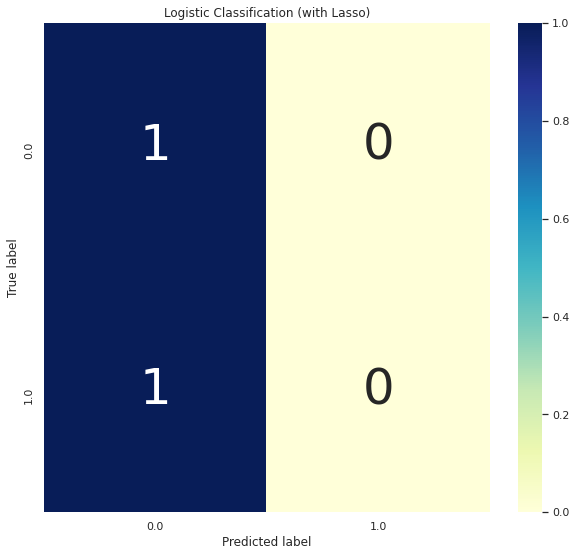

In [ ]:
cm2_norm = cm2 / cm2.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm2_norm, classes = rf_model.classes_, title='Logistic Classification (with Lasso)')

# <optimal threshold 구하기>
### 1.기대수익을 극대화하기 위해서는 threshold를 1단위(가령 1%p) 만큼 낮췄을 때 증가한 부도금액보다 증가한 이자수익이 더 크거나 같아야 함. 그리고 이 둘이 같아질 때가 최적의 threshold라고 할 수 있음.
### 2. 기대 이자수익을 구하기 위해 int_rate으로부터 class가 0인 사람들의 평균 이자율(약 12.2%)을 구함. 그리고 total_rec_prncp로부터 원금의 규모를 구함(이들은 돈을 다 갚았다는 사람들이므로 total_rec_prncp이 곧 대출금을 의미한다고 판단함). 이 값이 대략 \$13,500정도로 나옴.
### 3. 기대 부도금액을 추정하기 위해 class가 0인 사람들과 class가 1인 사람들의 대출금은 평균적으로 큰 차이가 없다고 가정을 함. 그 다음 class가 1인 사람들의 total_pymnt_inv	(약 \$9,100)로부터 원리금 회수율을 도출해보고자 함. 앞에서 구한 class 0인 사람들의 원금 규모로 class 1인 사람들의 갚은 원리금 규모를 나눴더니 약 67%가 나옴. 즉, 부도를 낸 사람들도 다 갚지는 못했으나 평균적으로 67%의 금액을 갚고 원금의 33%를 부도냈다는 것으로 해석할 수 있음.
### 4. 앞에서 이미 class 0과 class 1의 대출금액은 큰 차이가 없을 것이라 가정했으므로 기대수익을 확인하기 위해서는 절대적 금액이 아닌 이자율과 (회수율-100%)만 비교하면 됨. 즉, threshold를 1단위 낮춰서 class 1인 사람이 1명 늘어났다고 하면 67%-100%=-33%의 손실을 본 것과 같음. 대신 threshold를 낮추면서 class가 0인 사람들도 늘어날 것이므로 (늘어난 사람의 수)*12.2%의 수익을 보게 될 것임. 이로부터 늘어나는 class 0인 사람들이 늘어나는 class 1인 사람들의 2.75(=33%/12%)배 이상일 때 최적의 수익을 달성할 수 있으리라 기대 가능함. 
### 5. 이제 구체적으로 weight을 조정하는 방법에 대해 논하겠음. confusion matrix에서의 1종 오류율(실제는 0인데 1로 예측)과 2종 오류율(실제는 1인데 0으로 예측)만으로 판단하면 모집단의 크기를 고려하지 못하기 때문에 앞서 구한 class 0와 class 1의 전체 비율인 5:1을 고려해야 함. 앞서 4.에서 언급한 2.75배를 class 1에 곱해주고 5배를 class 0에 곱해주면 기대수익을 고려한 이들의 가중치가 나옴. 즉, class0는 class1보다 5/2.75=1.8배 중요하므로 threshold를 한 단위 낮출 때 줄어드는 1종 오류율이 증가하는 2종 오류율의 약 1.8배가 될 때 1-fpr과 tpr의 최적 weight가 된다는 것이 본인의 주장임. 단, 우리의 경우 threshold를 변화시켜 가면서 marginal한 1종 오류율의 변화와 2종 오류율의 변화를 관찰할 수 없으므로 weight를 grid search로 변화시켜 가면서 marginal 1종 오류율 =marginal 2종 오류율*1.8이 될 때를 최적의 weight로 구할 수 있고 이로부터 최적의 threshold를 구할 수 있음.